# BioSTEAM User Guide Tutorial - Beginner's Guide
this runs in Ubuntu 22.04.2 LTS on WSL2, Python 3.10.12\
install BioSTEAM with 'pip install biosteam'\
see https://biosteam.readthedocs.io/en/latest/tutorial/index.html

## 10. Creating a System
see https://biosteam.readthedocs.io/en/latest/tutorial/Creating_a_System.html
### 10.1. Conventional methods
#### 10.1.2 Autogenerated from the flowsheet


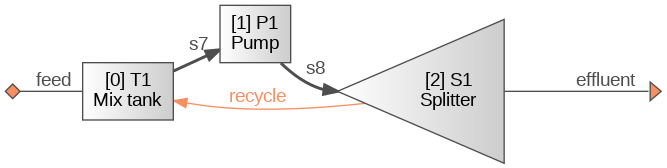

In [9]:
import biosteam as bst
bst.nbtutorial() # Ignore warnings and reset local BioSTEAM preferences
bst.settings.set_thermo(['Water'])
feed = bst.Stream('feed', Water=100)
recycle = bst.Stream('recycle')
effluent = bst.Stream('effluent')
T1 = bst.MixTank('T1', ins=[feed, recycle])
P1 = bst.Pump('P1', T1-0)
S1 = bst.Splitter('S1', P1-0, [effluent, recycle], split=0.5)
manual_sys = bst.System('manual_sys', path=[T1, P1, S1], recycle=recycle)
manual_sys.simulate()
manual_sys.diagram(
    kind='cluster', # Cluster diagrams highlight recycle streams and nested systems.
    number=True, # This numbers each unit according to their path simulation order
    format='png', # Easier to view the whole diagram
)

In [10]:
manual_sys.show()

System: manual_sys
Highest convergence error among components in recycle
stream S1-1 after 3 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
outs...
[0] effluent  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100


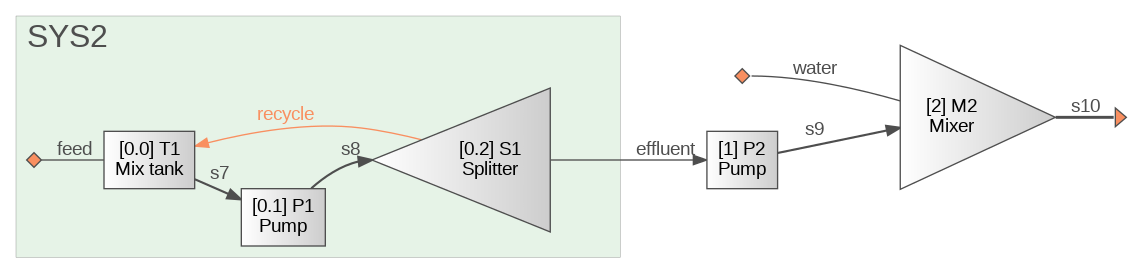

In [11]:
water = bst.Stream('water', Water=10)
P2 = bst.Pump('P2', manual_sys-0) # -pipe- notation equivalent to manual_sys.outs[0]
M2 = bst.Mixer('M2', [P2-0, water])
flowsheet_sys = bst.main_flowsheet.create_system('flowsheet_sys')
flowsheet_sys.simulate()

# Units in subsystems are numbered with after a "." to represent
# the subsystem depth (checkout SYS1 in the diagram)
flowsheet_sys.diagram(kind='cluster', number=True, format='png')

In [12]:
flowsheet_sys.show()

System: flowsheet_sys
Highest convergence error among components in recycle
stream S1-1 after 1 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  100
[1] water  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  10
outs...
[0] s10  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  110


#### 10.1.3. Autogenerated by context management
System objects’ context management feature allows for creating systems of only the units created within the given context:

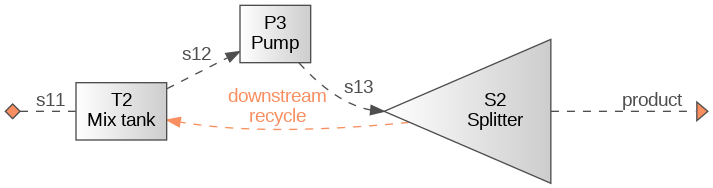

In [13]:
downstream_recycle = bst.Stream('downstream_recycle')
product = bst.Stream('product')
with bst.System('context_sys') as context_sys:
    T2 = bst.MixTank('T2', ins=['', downstream_recycle])
    P3 = bst.Pump('P3', T2-0)
    S2 = bst.Splitter('S2', P3-0, [product, downstream_recycle], split=0.5)
# The feed is empty, no need to run system (yet)
context_sys.diagram('cluster', format='png')

In [14]:
context_sys.show()

System: context_sys
ins...
[0] s11  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] product  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


Let’s connect two systems together and create a new system from the flowsheet:

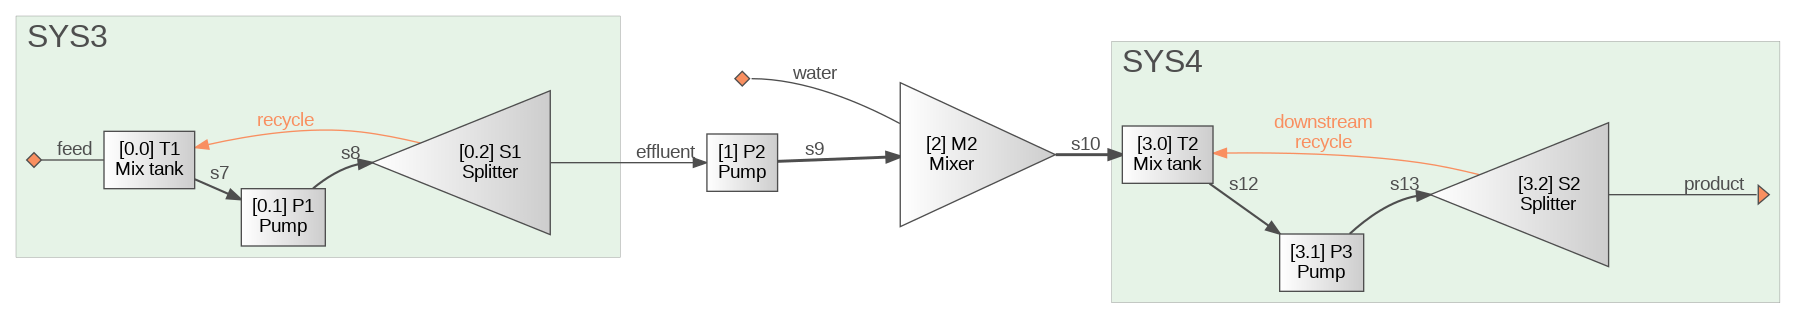

In [15]:
# -pipe- notation equivalent to context_sys.ins[:] = [flowsheet_sys.outs[0]]
flowsheet_sys-0-context_sys
complete_sys = bst.main_flowsheet.create_system('complete_sys')
complete_sys.simulate()
complete_sys.diagram('cluster', number=True, format='png')

## 10.2. Drop-in systems
### 10.2.1. A simple example
When a system is created by a function, it’s called a drop-in system. Here, we create a sugarcane to ethanol production system without facilities (e.g., cooling tower, boiler) by using drop-in systems:

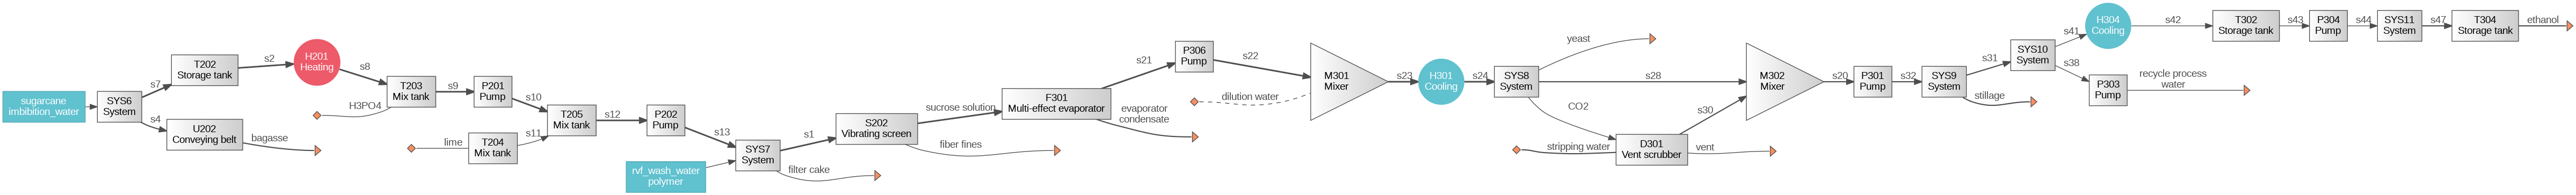

In [21]:
from biosteam import Stream, System, settings, main_flowsheet
from biorefineries.cane import (
    create_sugarcane_chemicals,
    create_juicing_system,
    create_sucrose_to_ethanol_system
)
chemicals = create_sugarcane_chemicals()
main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
settings.set_thermo(chemicals)
denaturant = Stream('denaturant',
                    Octane=230.69,
                    units='kg/hr',
                    price=0.756)
sucrose_solution = Stream('sucrose_solution')

juicing_sys = create_juicing_system(
    ID='juicing_sys', # ID of system
    outs=[sucrose_solution], # Place sucrose_solution at the 0th outlet (all other streams are defaulted)
)
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=[sucrose_solution, denaturant])

# Here are a couple of other ways to connect systems:
#   Manually:
#   >>> sucrose_to_ethanol_sys.ins[0] = juicing_sys.outs[0]
#   With -pipe- notation:
#   >>> juicing_sys-0-0-sucrose_to_ethanol_sys

# Manually create a new system to view a diagram of systems
sugarcane_to_ethanol_sys = System('sugarcane_to_ethanol_sys',
                                  path=[juicing_sys, sucrose_to_ethanol_sys])
sugarcane_to_ethanol_sys.simulate() # Simulate before showing results
sugarcane_to_ethanol_sys.diagram(kind='surface', format='png')

In [17]:
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
Highest convergence error among components in recycle
stream M201-0 after 3 loops:
- flow rate   1.08e+00 kmol/hr (0.03%)
- temperature 9.93e-02 K (0.03%)
ins...
[0] imbibition_water  
[1] sugarcane  
[2] rvf_wash_water  
[3] H3PO4  
[4] lime  
[5] polymer  
[6] stripping_water  
[7] dilution_water  
[8] denaturant  
outs...
[0] filter_cake  
[1] fiber_fines  
[2] bagasse  
[3] vent  
[4] evaporator_condensate  
[5] stillage  
[6] yeast  
[7] recycle_process_water  
[8] ethanol  


The number of inlets and outlets are rather large. It may be helpful to specify what inlets and outlets do we want to expose:

In [18]:
s = main_flowsheet.stream
sugarcane_to_ethanol_sys.load_inlet_ports([s.sugarcane], names={'feedstock': 0})
sugarcane_to_ethanol_sys.load_outlet_ports([s.ethanol, s.bagasse], names={'product': 0})
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
Highest convergence error among components in recycle
stream M201-0 after 3 loops:
- flow rate   1.08e+00 kmol/hr (0.03%)
- temperature 9.93e-02 K (0.03%)
ins...
[0] sugarcane  
outs...
[0] ethanol  
[1] bagasse  


The ethanol product is now the 0th stream

In [19]:
sugarcane_to_ethanol_sys.outs[0].show()

Stream: ethanol from <StorageTank: T304>
phase: 'l', T: 339.26 K, P: 101325 Pa
flow (kmol/hr): Water    10.4
                Ethanol  491
                Octane   4.39


We can also use the names we gave earlier for getting and setting streams:

In [20]:
print([sugarcane_to_ethanol_sys.get_inlet('feedstock'),
       sugarcane_to_ethanol_sys.get_outlet('product')])
# You can also use <System>.set_inlet(name, stream)

[<Stream: sugarcane>, <Stream: ethanol>]


#### 10.2.2. System factories
Both create_juicing_system and create_sucrose_to_ethanol_system are SystemFactory objects, which accept the system ID, ins, and outs (similar to unit operations) and return a new system. Let’s first have a look at some of the system factories in the biorefineries.sugarcane library:

In [ ]:
create_juicing_system.show()
print()
create_sucrose_to_ethanol_system.show()

SystemFactory objects are composed of a function f which creates the unit operations, a predefined system ID, and ins and outs dictionaries that serve as keyword arguments to initialize the system’s default inlets and outlets.

The signature of a SystemFactory is f(ID=None, ins=None, outs=None, mockup=False, area=None, udct=None, ...). The additional parameters (i.e. mockup, area, and udct) will be discussed in the next section.

#### 10.2.3. Mock systems
When creating a biorefinery, we may not be interested in all the subsystems we created with SystemFactory objects. We can save a few milliseconds in computational time (per system) by using mock systems:

In [ ]:
main_flowsheet.clear() # Remove previous unit operations to prevent ID-conflict warnings
juicing_sys = create_juicing_system(
    outs=[sucrose_solution],
    mockup=True
)
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
    ins=[sucrose_solution, denaturant],
    mockup=True
)
# Note that mock systems don't have anything other than `ins`, `outs`, and `units`
juicing_sys.show()
sucrose_to_ethanol_sys.show()

In [ ]:
# We can create the system using the flowsheet
sugarcane_to_ethanol_sys = main_flowsheet.create_system('sugarcane_to_ethanol_sys')
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram(format='png')

In [ ]:
sucrose_to_ethanol_sys.outs[0].show()

#### 10.2.4. Using the area naming convention
The area naming convention follows {letter}{area + number} where the letter depends on the unit operation as follows:

    C: Centrifuge
    D: Distillation column
    E: Evaporator
    F: Flash tank
    H: Heat exchange
    K: Compressor
    Ʞ: Turbine
    M: Mixer
    P: Pump (including conveying belt)
    R: Reactor
    S: Splitter (including solid/liquid separator)
    T: Tank or bin for storage
    U: Other units
    V: Valve
    J: Junction, not a physical unit (serves to adjust streams)
    PS: Process specificiation, not a physical unit (serves to adjust streams)

For example, the first mixer in area 100 would be named M101. When calling a SystemFactory object, we can pass the area to name unit operations according to the area convention. In the following example, we name all unit operations in the juicing system under area 300:

In [ ]:
main_flowsheet.clear() # Remove previous unit operations
juicing_sys = create_juicing_system(area=300, mockup=True)
juicing_sys.show()